In [7]:
import argparse
import csv

import math
import multiprocessing
import os
import random
import sys
from timeit import default_timer as timer
from operator import itemgetter
import dill
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from alipy.data_manipulate.al_split import split
from alipy.experiment.al_experiment import AlExperiment
from alipy.index import IndexCollection
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

font_size = 8

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    "axes.labelsize": font_size,
    "font.size": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "xtick.bottom":True,
    "figure.autolayout": True,
    
}

sns.set_style('white')
sns.set_context("paper")
plt.rcParams.update(tex_fonts)




# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 505.89


df = pd.read_csv("../datasets/ali/result.csv")

df['strategy'] = df['strategy'].map({
    "<class '__main__.Uncertainty'>{}":"MM1", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"ANNSingle10", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"ANNSingle1010", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingle1010New",
    "QueryInstanceUncertainty{'measure': 'margin'}":"MM2", 
    "QueryInstanceUncertainty{'measure': 'least_confident'}":"LC", 
    "QueryInstanceUncertainty{'measure': 'entropy'}":"Ent", 
    "QueryInstanceGraphDensity{}":"GD", 
    "QueryInstanceRandom{}":"Rand", 
    "QueryInstanceQUIRE{}":"QUIRE", 
    "QueryInstanceQBC{}":"QBC", 
    "QureyExpectedErrorReduction{}":"EER", 
    "QueryInstanceLAL{}": "LAL",
    "QueryInstanceSPAL{}": "SPAL",
    "QueryInstanceBMDR{}": "BMDR",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 200, 'TRUE_DISTANCES': True}":"ANNSingle200", 
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"NN Batch", 
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "NN Batch",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_cos_nrf.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': True}": "ANNSingleCosNrf",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_cos.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingleCos",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_nrf.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': True}" : "ANNSingleNrf",
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch_cos_nrf.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': True}": "ANNBatchCosNrf",
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch_cos.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "NN Batchcos",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingle1010EuclidCos",
    
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNeuc510",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNcos510",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 5, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNeuc55",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 5, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNcos55",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 1}": "NNeuc110",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 1}": "NNcos110",
    
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single1',
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single1cos',

     "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'INITIAL_BATCH_SAMPLING_ARG': 1, 'INITIAL_BATCH_SAMPLING_HYBRID_FURTHEST': 0, 'INITIAL_BATCH_SAMPLING_HYBRID_UNCERT': 0, 'INITIAL_BATCH_SAMPLING_METHOD': 'random'}": 'NN Batch1',
     "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'INITIAL_BATCH_SAMPLING_ARG': 1, 'INITIAL_BATCH_SAMPLING_HYBRID_FURTHEST': 0, 'INITIAL_BATCH_SAMPLING_HYBRID_UNCERT': 0, 'INITIAL_BATCH_SAMPLING_METHOD': 'random'}": 'NN Batch1cos'
})

# drop variants
df = df[df.strategy != 'MM1']
#df = df[df.strategy != 'ANNSingle1010']
df = df[df.strategy != 'ANNSingle200']
df = df[df.strategy != 'ANNSingle10']
df = df[df.strategy != 'ANNSingleCosNrf']
df = df[df.strategy != 'ANNSingleNrf']
df = df[df.strategy != 'ANNSingleCos']
df = df[df.strategy != 'ANNBatchCosNrf']
df = df[df.strategy != 'NN Batchcos']

df = df[df.strategy != 'NNeuc510']
df = df[df.strategy != 'NNcos510']
df = df[df.strategy != 'NNeuc55']
df = df[df.strategy != 'NNcos55']
df = df[df.strategy != 'NNeuc110']
df = df[df.strategy != 'NNcos110']

#df = df[df.strategy != 'NN Single1']
#df = df[df.strategy != 'NN Single1cos']
df = df[df.strategy != 'NN Single']
df = df[df.strategy != 'NN Batch1']
df = df[df.strategy != 'NN Batch1cos']



#for i in [13, 16, 21, 24,25,26]:
for i in [22,23,19, 24,25,26]:
    #for i in [22,23,19, 13,16,21]:
    df = df[df.dataset_id != i]

# it is the same as diabetes :(
df = df[df.dataset_id != 9]


df = df[df.dataset_id != 0] # synthetic
df = df[df.dataset_id != 7] # ILPD
#df = df[df.dataset_id != 5] # haberman
df = df[df.dataset_id != 1] #BREAST
df = df[df.dataset_id != 28] #parkinsons
df = df[df.dataset_id != 18] # wine

    
#errors on this dataset
df = df[df.dataset_id != 20]

#toy dataset
df = df[df.dataset_id != 21]

# filter out partial results
df = df[(df.strategy != 'SPAL') | (df.dataset_id != 12)]
df = df[(df.strategy != 'LAL') | (df.dataset_id != 13)]


print(len(df[(df.strategy == 'EER') & (df.dataset_id == 12)]))

# filter out duplicates
df = df.drop_duplicates(subset=['strategy_id', 'dataset_id', 'dataset_random_seed'], keep='last')

df['strategy'] = df['strategy'].replace({
    'MM1':'MM',
    'MM2': 'MM',
    'ANNSingle1010': 'NN Single',
    'ANNSingle1010New': 'NN Single',
})


# remove NN Single
df = df[(df.strategy != 'NN Single')]
#df = df[(df.strategy != 'NN Single1')]
#df = df[(df.strategy != 'NN Single1cos')]

df = df [(df.strategy != 'ANNSingle1010EuclidCos')]
print(df['strategy'].unique())




# dasselbe für strategy_ids machen


old_strategy_to_id= {
    2: "QBC",
    3: "LC",
    4: "MM",
    5: "Ent",
    6: "Rant",
    7: "EER",
    8: "GD",
    9: "QUIRE",
    10: "LAL", 
    11: "BMDR",  
    12: "SPAL",  
    32: "NN Single1",
    33: "NN Single1cos",
    13: "NN Batch",
    
}

old_strategy_to_id = {y:x for x,y in old_strategy_to_id.items()}

new_strategy_to_id = {
    1: "QBC",
    2: "LC",
    3: "MM",
    4: "Ent",
    5: "Rant",
    6: "EER",
    7: "GD",
    8: "QUIRE",
    9: "LAL", 
    10: "BMDR",  
    11: "SPAL",  
    12: "NN Single1",
    13: "NN Single1cos",
    14: "NN Batch",
    
}

new_strategy_to_id = {y:x for x,y in new_strategy_to_id.items()}

# old dataset_id -> new dataset_id
mapping_dict = {}

for dataset_name in new_strategy_to_id.keys():
    mapping_dict[old_strategy_to_id[dataset_name]] = new_strategy_to_id[dataset_name]

print(mapping_dict)

df = df.replace({"strategy_id": mapping_dict})


df['strategy'] = df['strategy'].replace({
      'NN Single1': "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}",
      'NN Single1cos': "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}",
      'NN Batch': "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '../trained strategies/batch.pickle', 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}",
        
      "MM": "QueryInstanceUncertainty{'measure': 'margin'}", 
      "LC": "QueryInstanceUncertainty{'measure': 'least_confident'}", 
      "Ent": "QueryInstanceUncertainty{'measure': 'entropy'}", 
      "GD": "QueryInstanceGraphDensity{}", 
      "Rand": "QueryInstanceRandom{}", 
      "QUIRE": "QueryInstanceQUIRE{}", 
      "QBC": "QueryInstanceQBC{}", 
      "EER": "QureyExpectedErrorReduction{}", 
      "LAL": "QueryInstanceLAL{}",
      "SPAL": "QueryInstanceSPAL{}",
      "BMDR": "QueryInstanceBMDR{}",
})


old_dataset_to_id= {
        0:"synthetic",                                                               
        1:   "breast",                                                                            
        2:   "diabetes",                                                                          
        3:   "fertility",                                                                         
        4:   "german",                                                                            
        5:   "haberman",                                                                          
        6:   "heart",                                                                             
        7:   "ILPD",                                                                              
        8:   "ionosphere",                                                                        
        9:   "pima",                                                                              
        10:   "planning",                                                                         
        11:   "australian",                                                                       
        12:   "DWTC",    
        13: "EMNIST",
        14: "glass",
        15: "olivetti",
        16: "CIFAR-10",
        18: "wine",
        19: "adult50",
        20: "abalone",
        21: "adult1000",
        22: "emnist50",
        23: "cifar1050",
        24: "adult100",
        25: "emnist100",
        26: "cifar10100",
        27: "zoo",
        28: "parkinsons",
        29: "flags",
    
}

old_dataset_to_id = {y:x for x,y in old_dataset_to_id.items()}

new_dataset_to_id = {
    1: "fertility",
    2: "german",
    3: "diabetes",
    4: "ionosphere",
    5: "planning",
    6: "australian",
    7: "DWTC",
    8: "EMNIST",
    9: "glass",
    10: "olivetti",
    11: "CIFAR-10",
    12: "haberman",
    13: "zoo",
    14: "flags",
    15: "heart",
}

new_dataset_to_id = {y:x for x,y in new_dataset_to_id.items()}

# old dataset_id -> new dataset_id
mapping_dict = {}

for dataset_name in new_dataset_to_id.keys():
    mapping_dict[old_dataset_to_id[dataset_name]] = new_dataset_to_id[dataset_name]

print(mapping_dict)

df = df.replace({"dataset_id": mapping_dict})

df = df.drop_duplicates(subset=['strategy', 'dataset_id', 'dataset_random_seed'], keep='last')


# ab hier dann das csv was ich am Ende präsentiere
df.to_csv('result.csv', index=False)


df['strategy'] = df['strategy'].replace({
        "QueryInstanceUncertainty{'measure': 'margin'}":"MM", 
    "QueryInstanceUncertainty{'measure': 'least_confident'}":"LC", 
    "QueryInstanceUncertainty{'measure': 'entropy'}":"Ent", 
    "QueryInstanceGraphDensity{}":"GD", 
    "QueryInstanceRandom{}":"Rand", 
    "QueryInstanceQUIRE{}":"QUIRE", 
    "QueryInstanceQBC{}":"QBC", 
    "QureyExpectedErrorReduction{}":"EER", 
    "QueryInstanceLAL{}": "LAL",
    "QueryInstanceSPAL{}": "SPAL",
    "QueryInstanceBMDR{}": "BMDR",
    
    
      "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single',
      "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../trained strategies/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single cos',
      "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '../trained strategies/batch.pickle', 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Batch',
})


# rename back to <clas '__main' etc
# rename then HERE to the names of the 


print(df['strategy'].unique())

large_datasets_where_cosine_is_better_for_single = [7,8,10,11]

for dataset_id in large_datasets_where_cosine_is_better_for_single:
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != dataset_id)]

df = df[(df.strategy != 'NN Single cos') | (df.dataset_id.isin(large_datasets_where_cosine_is_better_for_single))]


df['strategy'] = df['strategy'].replace({
      'NN Single cos': 'NN Single',
})





# use cosine similarity for large datasets
df = df.drop_duplicates(subset=['strategy', 'dataset_id', 'dataset_random_seed'], keep='last')

print(df['strategy'].unique())
print(df['strategy_id'].unique())

df

200
['MM' 'LC' 'Ent' 'Rand' 'GD' 'QUIRE' 'QBC' 'EER' 'NN Batch' 'NN Single1'
 'NN Single1cos' 'LAL' 'SPAL' 'BMDR']
{2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 32: 12, 33: 13, 13: 14}
{3: 1, 4: 2, 2: 3, 8: 4, 10: 5, 11: 6, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 5: 12, 27: 13, 29: 14, 6: 15}
['MM' 'LC' 'Ent' 'Rand' 'GD' 'QUIRE' 'QBC' 'EER' 'NN Batch' 'NN Single'
 'NN Single cos' 'LAL' 'SPAL' 'BMDR']
['MM' 'LC' 'Ent' 'Rand' 'GD' 'QUIRE' 'QBC' 'EER' 'NN Batch' 'NN Single'
 'LAL' 'SPAL' 'BMDR']
[ 3  2  4  5  7  8  1  6 14 12 13  9 11 10]


,numqdata,round,init_labeled_size,num_of_queries,cost,performance,performance_plus_minus,dataset_id,strategy_id,dataset_random_seed,...,n_redundant,n_repeated,n_classes,n_clusters_per_class,weights,flip_y,class_sep,hypercube,scale,random_state
2,48,0,2,10,0,0.929415,0.014659,1,3,2,...,0,0,2,0,0,0.0,0.0,0,0.0,2
3,48,0,2,10,0,0.903619,0.085935,1,2,9,...,0,0,2,0,0,0.0,0.0,0,0.0,9
4,48,0,2,10,0,0.840795,0.169882,1,3,4,...,0,0,2,0,0,0.0,0.0,0,0.0,4
5,48,0,2,10,0,0.903605,0.041869,1,2,7,...,0,0,2,0,0,0.0,0.0,0,0.0,7
6,48,0,2,10,0,0.787143,0.217998,1,2,6,...,0,0,2,0,0,0.0,0.0,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58922,43,0,7,9,0,0.934560,0.019395,13,9,96,...,0,0,7,0,0,0.0,0.0,0,0.0,96
58923,43,0,7,9,0,0.817690,0.040655,13,9,97,...,0,0,7,0,0,0.0,0.0,0,0.0,97
58924,43,0,7,9,0,0.947835,0.009473,13,9,95,...,0,0,7,0,0,0.0,0.0,0,0.0,95
58925,43,0,7,9,0,0.882504,0.075723,13,9,98,...,0,0,7,0,0,0.0,0.0,0,0.0,98


In [8]:
df.value_counts(subset=['strategy'])

strategy 
Ent          1479
GD           1479
LC           1479
MM           1479
NN Batch     1479
NN Single    1479
QBC          1479
Rand         1479
LAL          1379
EER          1279
QUIRE        1279
BMDR         1179
SPAL         1078
dtype: int64

    strategy dataset_id       duration
172     SPAL          1       6.327574
173     SPAL          2     974.737428
174     SPAL          3     350.478815
175     SPAL          4      33.151179
176     SPAL          5      13.336097
177     SPAL          6     227.783949
178     SPAL          9       8.664658
179     SPAL         10      42.856895
180     SPAL         13      10.738109
181     SPAL         14      23.586630
182     SPAL         15      25.107502
187     SPAL         13  604800.000000
189     SPAL         12  604800.000000
193     SPAL         16  604800.000000
      strategy dataset_id     duration
114  NN Single          1     6.867454
115  NN Single          2    28.636583
116  NN Single          3    28.361288
117  NN Single          4    20.524080
118  NN Single          5    11.700790
119  NN Single          6    28.397223
120  NN Single          7    30.655202
121  NN Single          8  7850.584493
122  NN Single          9    12.809698
123  NN Single         10

<AxesSubplot:>

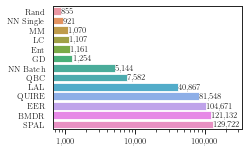

In [9]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.15
                value = int(p.get_width())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


plt.figure(figsize=set_size(width, fraction=0.5))
from numpy import median
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator


df_dur = df.groupby(['strategy', 'dataset_id'])['duration'].mean().to_frame()
df_dur = df_dur.reset_index()  

#print(df_dur.loc[df_dur['strategy']=='Rand'])
#print(df_dur.loc[df_dur['strategy']=='NN Single'])
#print(df_dur.loc[df_dur['strategy']=='MM'])

df_dur2 =  df.groupby(['strategy'])['duration'].mean().to_frame()

timout_duration = 604800
#timout_duration = 259200

# timeout
df_dur = df_dur.append({'strategy':'LAL', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)

df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'12', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'12', 'duration':timout_duration}, ignore_index=True)


df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)


print(df_dur[df_dur['strategy'] == 'SPAL'])
print(df_dur[df_dur['strategy'] == 'NN Single'])

#print(df_dur.loc[df_dur['strategy'] =='LAL']['duration'].mean())

#print(df_dur.loc[df_dur['strategy'] =='Rand']['duration'].mean())

df_hist_new = pd.DataFrame(columns=['strategy', 'duration'])
for strategy in df.strategy.unique():
    df_hist_new = df_hist_new.append({
        'strategy':strategy, 
        'duration': df_dur.loc[df_dur['strategy'] ==strategy]['duration'].mean()
    }, ignore_index=True)

#print(df_hist_new)

df_hist_new = df_hist_new.sort_values(by=['duration'])
g = sns.barplot(data=df_hist_new, x="duration", y="strategy")#, ci=68, capsize=.3)#, fill=True, common_norm=False, alpha=.5, linewidth=0)
show_values_on_bars(g, "h", 10.4)
g.set_xscale("log")
#g.xaxis.set_minor_locator(AutoMinorLocator(5))

#print(g.get_xlim())
g.set_xlim(g.get_xlim()[0],g.get_xlim()[1]+170000)

import matplotlib.ticker
g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
g.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
g.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

g.xaxis.tick_bottom()
g.set_xlabel("")
#g.set_xlabel("duration in s (walltime)")
g.set_ylabel("")
g.get_figure().savefig('../paper/figures/performance.pdf', format='pdf', bbox_inches='tight')
g


In [10]:
from tabulate import tabulate
dataset_to_id= {
        1: "fertility",
    2: "german",
    3: "diabetes",
    4: "ionosphere",
    5: "planning",
    6: "australian",
    7: "DWTC",
    8: "EMNIST",
    9: "glass",
    10: "olivetti",
    11: "CIFAR-10",
    12: "haberman",
    13: "zoo",
    14: "flags",
    15: "heart",
    
}


dataset_names = ['strategy'] + [dataset_to_id[id] for id in df['dataset_id'].unique()]
strategy_results = []
strategy_results.append(dataset_names)

def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    
    m2 = {}
    last_value = -1
    increase = 0
    for i, v in enumerate(sorted(ranks)):
        if last_value == v:
            increase += 1
            m2[v] = v
        else:
            m2[v] = v+increase
        last_value = v
    
    #ranks = [m2[x] for x in ranks]
    return ranks

for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.40f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['f1_auc'].mean()))
         
        results = [r if r != "nan" else -0 for r in results] 
     
    strategy_results.append(results)
    
results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(-1, np.NaN)
results_df = results_df.apply(pd.to_numeric)

results_df['mean'] = results_df.T.mean(skipna=True)


ranking_only_table = []
transposed_results = list(map(list, zip(*strategy_results)))
new_results = [transposed_results[0]]
for row in transposed_results[1:]:
    row_sorting = get_ranks(np.array(row[1:]))
    row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
    new_results.append(row)
    ranking_only_table.append(row[:1] + row_sorting)

row = ["mean %"] + results_df['mean'].to_list()
row_sorting = get_ranks(np.array(row[1:]))

row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
new_results.append(row)


ranking_only_table = [transposed_results[0]] + ranking_only_table
new_results.append(["mean (r)"] + ["{:1.2f}".format(sum(r)/len(r)) for r in list(map(list, zip(*ranking_only_table[1:])))[1:]])


# sort colmuns manually
df2 = pd.DataFrame(new_results[1:], columns=new_results[0])
df2 = df2[['strategy', 'NN Single', 'NN Batch', 'MM', 'QBC', 'LC', 'GD', 'BMDR', 'Ent', 'LAL', 'SPAL', 'EER', 'QUIRE','Rand']]

order = ['strategy'] + sorted([v for v in dataset_to_id.values()], key=lambda v: v.upper()) + ['mean %', 'mean (r)']
lol = [df2.columns.values.tolist()] + df2.values.tolist()
lol = sorted(lol, key=lambda l: order.index(l[0]))

with open('../paper/figures/ali_f1auc_table.tex2', "w") as f:
    tex_code = tabulate(lol, headers="firstrow", tablefmt="latex_booktabs")
    splitted = ["\\fontseries{b}\\selectfont{" + t[1:-1] + "}" if "(0)" in t else t for t in tex_code.split("&") ]
    
    
    tex_code = "&".join(splitted)
    tex_code = tex_code.replace("llllllllllllll", "L{1.4cm}cccccccccccccc")
    
    tex_code = tex_code.replace("tabular", "tabularx")
    tex_code = tex_code.replace("begin{tabularx}", "begin{tabularx}{\linewidth}")

    tex_code = tex_code.replace("mean \%", "\\midrule \n mean \%")
    tex_code = tex_code.replace(" \\% ", "~~~")
    tex_code = tex_code.replace("\\% ", " ")
    tex_code = tex_code.replace("~~~", " \\%")
    for ind in range(0,100):
        tex_code = tex_code.replace(" 0.0 ("+str(ind)+")", "")
        
    tex_code = tex_code.replace("1.36", "\\fontseries{b}\\selectfont{1.36}")
    tex_code = tex_code.replace(" \\\\", "\\\\")
    tex_code = tex_code.replace("cc", "rr")
    tex_code = tex_code.replace("strategy", "")
    f.write(tex_code)
    
tabulate(lol, headers="firstrow", tablefmt="html")


strategy,NN Single,NN Batch,MM,QBC,LC,GD,BMDR,Ent,LAL,SPAL,EER,QUIRE,Rand
australian,85.4% (0),85.3% (4),85.4% (2),85.3% (3),85.4% (1),85.2% (5),85.1% (7),85.4% (2),85.2% (6),84.3% (10),84.6% (9),76.2% (11),84.9% (8)
CIFAR-10,37.0% (0),36.9% (1),36.9% (2),36.0% (5),35.9% (6),36.3% (4),0.0% (9),35.7% (7),34.9% (8),0.0% (9),0.0% (9),0.0% (9),36.8% (3)
diabetes,74.3% (4),74.5% (2),74.3% (5),74.4% (3),74.3% (6),75.0% (0),74.7% (1),74.3% (5),74.3% (7),73.9% (10),74.2% (9),66.5% (11),74.2% (8)
DWTC,74.9% (0),74.1% (2),74.7% (1),71.7% (6),71.0% (7),65.1% (9),0.0% (11),68.5% (8),72.2% (5),0.0% (11),72.8% (4),53.4% (10),72.9% (3)
EMNIST,69.1% (1),68.6% (2),69.5% (0),63.4% (4),61.6% (5),43.8% (7),0.0% (8),59.2% (6),0.0% (8),0.0% (8),0.0% (8),0.0% (8),66.1% (3)
fertility,88.5% (3),88.3% (4),88.0% (8),88.2% (6),88.0% (8),88.3% (5),88.6% (2),88.0% (9),88.0% (7),88.6% (1),86.6% (11),89.1% (0),87.4% (10)
flags,57.7% (0),56.4% (5),56.6% (4),55.9% (9),55.4% (10),57.0% (2),57.4% (1),54.7% (11),55.9% (8),56.9% (3),56.0% (7),50.4% (12),56.2% (6)
german,75.7% (2),75.6% (3),75.4% (9),75.5% (6),75.4% (10),76.2% (1),75.6% (5),75.4% (11),75.5% (7),76.5% (0),75.4% (8),70.9% (12),75.6% (4)
glass,69.0% (0),68.1% (2),68.6% (1),67.5% (6),68.0% (3),66.4% (8),67.6% (5),66.3% (9),66.0% (10),61.7% (11),67.2% (7),48.2% (12),67.6% (4)
haberman,72.9% (4),72.3% (5),72.9% (3),73.3% (0),72.9% (1),71.6% (8),71.6% (9),72.9% (2),72.3% (6),0.0% (12),72.0% (7),63.2% (11),71.5% (10)


# 